In [69]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
import pandas as pd
from surprise import KNNBasic
from sklearn.preprocessing import StandardScaler
from umap import umap_
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from sklearn.metrics.pairwise import cosine_similarity

---
---

# CLEANING

In [20]:
ratings = pd.read_csv('data/raw/ratings.csv')
movies  = pd.read_csv('data/raw/movies.csv')
users   = pd.read_csv('data/raw/users.csv')

In [24]:
movies['release_year'] = movies['release_date'].apply(lambda x: x.split('-')[-1] if not pd.isna(x) else pd.NA)

In [52]:
def get_genres(row):
    row_dict = dict(row)

    genres = []

    for key in row_dict:
        if key != 'movie_id' and isinstance(row_dict[key],int):
            if row_dict[key] == 1:
                genres += [key]
    
    return ','.join(genres)

movies['genres'] = movies.apply(get_genres,axis=1)

In [65]:
movie_genres = movies.groupby('genres').count()[['movie_id']].rename({'movie_id':'count'},axis=1).sort_values(by='count',ascending=False)

In [66]:
movie_genres.to_csv('data/processed/genres.csv')

In [4]:
id2movie = movies.set_index('movie_id')['movie_title'].to_dict()

In [32]:
features = movies.select_dtypes(include=['number']).drop(['movie_id'],axis=1)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

In [34]:
umap_reducer = umap_.UMAP(n_components=3, random_state=42)
umap_data = umap_reducer.fit_transform(normalized_data)

movies['UMAP1'] = umap_data[:,0]
movies['UMAP2'] = umap_data[:,1]
movies['UMAP3'] = umap_data[:,2]

C:\Users\UY641FU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


C:\Users\UY641FU\AppData\Local\Temp\ipykernel_117844\2762033462.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


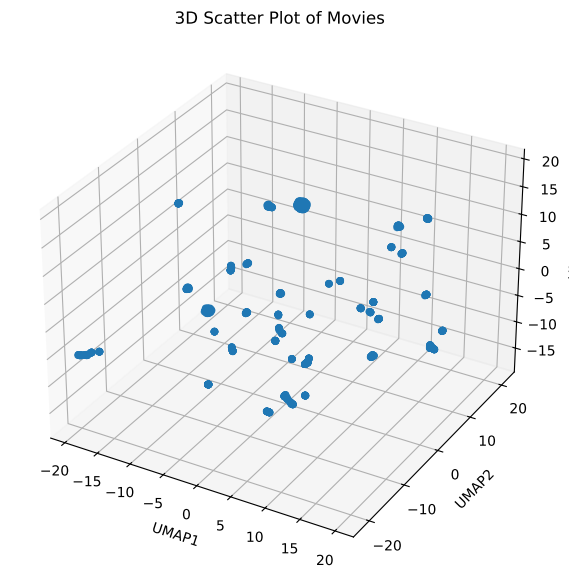

In [43]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = movies['UMAP1']  
y = movies['UMAP2']  
z = movies['UMAP3']  

# Create the scatter plot
# scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)
scatter = ax.scatter(x, y, z, s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Movies')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

# Add white outlines to all text elements (axes labels, ticks, and titles)
ax = plt.gca()
texts = [ax.title, ax.xaxis.label, ax.yaxis.label, ax.zaxis.label]  # Title, xlabel, ylabel
texts += ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels() # Tick labels

# Apply white outlines to each text object
for text in texts:
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'),  # White outline
        path_effects.Normal()  # Normal text rendering
    ])

plt.tight_layout()

plt.savefig('artifacts/imgs/3D_movies.png', transparent=True)

plt.show()

---
---

# USER BASED COLLABORATIVE FILTERING

In [5]:
reader = Reader(rating_scale=(1, 5))  # Assuming ratings range from 1 to 5
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)


In [6]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)


In [7]:
sim_options = {
    "name": "cosine",      # Similarity metric: cosine similarity
    "user_based": True     # Set to False for item-based filtering
}

umodel = KNNBasic(sim_options=sim_options)
umodel.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [8]:
predictions = umodel.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 1.0223


In [9]:
def get_ubased_predictions(user_id):
    # List of all movie IDs
    all_movie_ids = ratings['movie_id'].unique()

    # Get seen movies for the user
    seen_movies = ratings[ratings['user_id'] == user_id]['movie_id'].tolist()

    # Predict ratings for unseen movies
    unseen_movies = [movie for movie in all_movie_ids if movie not in seen_movies]
    predictions = [umodel.predict(user_id, movie) for movie in unseen_movies]

    # Sort by predicted rating
    top_movies = sorted(predictions, key=lambda x: x.est, reverse=True)[:10]

    # Display top recommendations
    print("Top 10 Recommended Movies:")
    for pred in top_movies:
        print(f"Movie: {id2movie[pred.iid]}, Predicted Rating: {pred.est:.2f}")


In [11]:
get_ubased_predictions(823)

Top 10 Recommended Movies:
Movie: Santa with Muscles (1996), Predicted Rating: 5.00
Movie: Aiqing wansui (1994), Predicted Rating: 5.00
Movie: Golden Earrings (1947), Predicted Rating: 5.00
Movie: Star Kid (1997), Predicted Rating: 5.00
Movie: Someone Else's America (1995), Predicted Rating: 5.00
Movie: Little City (1998), Predicted Rating: 5.00
Movie: Entertaining Angels: The Dorothy Day Story (1996), Predicted Rating: 5.00
Movie: Saint of Fort Washington, The (1993), Predicted Rating: 5.00
Movie: They Made Me a Criminal (1939), Predicted Rating: 5.00
Movie: Marlene Dietrich: Shadow and Light (1996) , Predicted Rating: 5.00


---
---

# ITEM BASED COLLABORATIVE FILTERING

In [12]:
sim_options = {
    "name": "cosine",      # Similarity metric: cosine similarity
    "user_based": False    # Set to False for item-based filtering
}

imodel = KNNBasic(sim_options=sim_options)
imodel.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [13]:
predictions = imodel.test(testset)
rmse = accuracy.rmse(predictions)


RMSE: 1.0321


In [14]:
def get_ibased_predictions(user_id):
    # List of all movie IDs
    all_movie_ids = ratings['movie_id'].unique()

    # Get seen movies for the user
    user_id = 1
    seen_movies = ratings[ratings['user_id'] == user_id]['movie_id'].tolist()

    # Predict ratings for unseen movies
    unseen_movies = [movie for movie in all_movie_ids if movie not in seen_movies]
    predictions = [imodel.predict(user_id, movie) for movie in unseen_movies]

    # Sort by predicted rating
    top_movies = sorted(predictions, key=lambda x: x.est, reverse=True)[:10]

    # Display top recommendations
    print("Top 10 Recommended Movies:")
    for pred in top_movies:
        print(f"Movie ID: {id2movie[pred.iid]}, Predicted Rating: {pred.est:.2f}")

In [79]:
get_ibased_predictions(823)

Top 10 Recommended Movies:
Movie ID: Coldblooded (1995), Predicted Rating: 4.53
Movie ID: Visitors, The (Visiteurs, Les) (1993), Predicted Rating: 4.43
Movie ID: Cyclo (1995), Predicted Rating: 4.40
Movie ID: Birds, The (1963), Predicted Rating: 4.33
Movie ID: Hearts and Minds (1996), Predicted Rating: 4.33
Movie ID: Chairman of the Board (1998), Predicted Rating: 4.29
Movie ID: To Kill a Mockingbird (1962), Predicted Rating: 4.25
Movie ID: One Flew Over the Cuckoo's Nest (1975), Predicted Rating: 4.25
Movie ID: Three Lives and Only One Death (1996), Predicted Rating: 4.22
Movie ID: Death in Brunswick (1991), Predicted Rating: 4.21


---
---

# CONTENT BASED FILTERING

In [70]:
# compute the simalirities between movies based on genres

cosine_sim = cosine_similarity(features, features)

In [86]:
movie_indices = pd.Series(movies.index, index=movies['movie_title']).drop_duplicates()

def recommend_movies(title, cosine_sim=cosine_sim, movies_df=movies, movie_indices=movie_indices):
    # Get the index of the movie
    idx = movie_indices[title]

    # Get similarity scores for this movie with all others
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort movies by similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the 10 most similar movies
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies_df['movie_title'].iloc[movie_indices]

def recommend_for_user(user_id, cosine_sim=cosine_sim, movies_df=movies, ratings_df=ratings):
   
    # Get the movies the user has rated highly
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= 4.0]['movie_id']

    # Aggregate recommendations from liked movies
    recommendations = []
    for movie_id in liked_movies:
        movie_title = movies_df[movies_df['movie_id'] == movie_id]['movie_title'].values[0]
        recommendations.extend(recommend_movies(movie_title).values)

    # Return unique recommendations
    return list(set(recommendations))

In [88]:
user_recommendations = recommend_for_user(823)
print("User Recommendations:")
print(user_recommendations)


User Recommendations:
['Four Weddings and a Funeral (1994)', 'Meet Me in St. Louis (1944)', 'Chasing Amy (1997)', 'Nightmare Before Christmas, The (1993)', 'Aladdin and the King of Thieves (1996)', 'Forbidden Planet (1956)', 'Mars Attacks! (1996)', 'Thin Blue Line, The (1988)', 'Sleepers (1996)', 'Platoon (1986)', 'Twelve Monkeys (1995)', 'Clockwork Orange, A (1971)', 'Romper Stomper (1992)', 'Truth or Consequences, N.M. (1997)', 'Casablanca (1942)', 'Tainted (1998)', 'Guilty as Sin (1993)', 'Diabolique (1996)', 'Species (1995)', 'Big Lebowski, The (1998)', 'Sling Blade (1996)', 'Homeward Bound: The Incredible Journey (1993)', 'Something to Talk About (1995)', 'Mask, The (1994)', 'Fantasia (1940)', 'Desperado (1995)', "Devil's Advocate, The (1997)", 'Brothers McMullen, The (1995)', 'Hudsucker Proxy, The (1994)', 'In the Army Now (1994)', 'Dark City (1998)', 'Madame Butterfly (1995)', 'Dumbo (1941)', 'Basic Instinct (1992)', 'Back to the Future (1985)', 'Courage Under Fire (1996)', 'Blu